# Macro-Driven S&P 500 Volatility Modelling with Elastic Net

This notebook builds a macro- and market-driven model for 21-day realized volatility of the S&P 500 [finance:S&P 500].  
It compares a baseline Ordinary Least Squares (OLS) regression with an Elastic Net model, using a time-series train/test split and separate evaluation for normal and stress volatility regimes.


In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt

# Add the project root to Python path
project_root = Path.cwd().parent  # if notebook is in notebooks/ folder
sys.path.append(str(project_root))

import pandas as pd

from src.config import ModelParams
from src.data_loader import download_market_data_stooq, download_fred_data, merge_market_macro
from src.features import build_feature_frame, dispersion_diagnostics
from src.model import (
    time_series_train_test_split,
    fit_models_with_timeseries_cv,
    report_results,
)


## Configuration

Set global modelling parameters (lookback horizon, volatility window, and Elastic Net hyperparameter grid).



In [2]:
params = ModelParams()
params

ModelParams(end_date=datetime.date(2025, 11, 30), lookback_years=7, sp500_symbol='^GSPC', vxx_symbol='VXX.US', hyg_symbol='HYG', lqd_symbol='LQD', fred_series={'EFFR': 'EFFR', 'BAA10Y': 'BAA10Y'}, vol_window=21, macro_lag_days=5, test_size_fraction=0.3, n_splits=10, max_iter=10000, l1_ratios=array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]), alphas=array([1.00000000e-03, 1.20679264e-03, 1.45634848e-03, 1.75751062e-03,
       2.12095089e-03, 2.55954792e-03, 3.08884360e-03, 3.72759372e-03,
       4.49843267e-03, 5.42867544e-03, 6.55128557e-03, 7.90604321e-03,
       9.54095476e-03, 1.15139540e-02, 1.38949549e-02, 1.67683294e-02,
       2.02358965e-02, 2.44205309e-02, 2.94705170e-02, 3.55648031e-02,
       4.29193426e-02, 5.17947468e-02, 6.25055193e-02, 7.54312006e-02,
       9.10298178e-02, 1.09854114e-01, 1.32571137e-01, 1.59985872e-01,
       1.93069773e-01, 2.32995181e-01, 2.81176870e-01, 3.39322177e-01,
       4.09491506e-01, 4.94171336e-01, 5.96362332e-01, 7.

## Data Loading

Market data is downloaded from Stooq (S&P 500 index, HYG.US, LQD.US, VXX.US) and macro data from FRED (Fed Funds, CPI, BAA10Y spread).  
All series are aligned on a daily calendar and forward-filled where necessary.


In [3]:
print("Downloading market data from Stooq...")
market_df = download_market_data_stooq(params)
print(market_df.head(), market_df.shape)

print("\nDownloading macro data from FRED...")
macro_df = download_fred_data(params)
print(macro_df.head(), macro_df.shape)

print("\nMerging market and macro data...")
merged_df = merge_market_macro(market_df, macro_df)
print(merged_df.head(), merged_df.shape)

SPX ^SPX Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
HYG HYG.US Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
LQD LQD.US Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
VXX VXX.US Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
              ^GSPC      HYG      LQD   VXX.US
Date                                          
2018-12-03  2790.37  75.0327  104.065  2086.40
2018-12-04  2700.06  74.5653  104.085  2357.76
2018-12-06  2695.95  74.3053  104.394  2418.56
2018-12-07  2633.08  74.1614  104.404  2580.48
2018-12-10  2637.72  74.2179  104.712  2555.52 (1757, 4)

            EFFR  BAA10Y
DATE                    
2018-12-03  2.19    2.26
2018-12-04  2.20    2.25
2018-12-05  2.20     NaN
2018-12-06  2.20    2.29
2018-12-07  2.19    2.31 (1823, 2)

Merging market and macro data...
              ^GSPC      HYG      LQD   VXX.US  EFFR  BAA10Y
2018-12-03  2790.37  75.0327  104.065  2086.40  2.19    2.26
2018-12-04  2

## Feature Engineering and Volatility Diagnostics

The target variable is log 21-day realized volatility of the S&P 500.  
Independent variables include credit spreads, inflation, policy rate, high-yield and investment-grade returns, VIX-linked ETN returns, and several interaction / non-linear terms (e.g. squared credit spread, SP\_RET × VXX\_RET).  
This section constructs the feature matrix and visualizes the volatility series to confirm behaviour over time.


In [4]:
features_df = build_feature_frame(merged_df, params)
print("Feature frame shape:", features_df.shape)
features_df.tail()


Feature frame shape: (1735, 13)


,SPX_21D_REALIZED_VOL,SP_RET,HYG_RET,LQD_RET,VXX_RET,CREDIT_SPREAD,CREDIT_SPREAD_DIFF,EFFR_LAG,BAA10Y_LAG,VOL_LAG,CREDIT_SPREAD_SQ,HYG_RET_X_SPREAD,SP_RET_X_VXX
2025-11-20,-1.972177,-0.015567,-0.000624,0.001359,0.071952,-30.43,-0.20,3.88,1.77,-2.026908,925.9849,0.018983,-0.001120
2025-11-21,-1.949685,0.009823,0.003371,0.003528,-0.054711,-30.55,-0.12,3.88,1.77,-2.020975,933.3025,-0.102978,-0.000537
2025-11-24,-1.894355,0.015467,0.002737,0.003967,-0.068060,-30.77,-0.22,3.88,1.77,-2.017373,946.7929,-0.084228,-0.001053
2025-11-25,-1.915133,0.009062,0.003474,0.002784,-0.031627,-30.80,-0.03,3.88,1.79,-1.984022,948.6400,-0.107011,-0.000287
2025-11-26,-1.901358,0.006907,0.000989,0.003403,-0.027019,-31.10,-0.30,3.88,1.79,-1.984207,967.2100,-0.030765,-0.000187


Running dispersion diagnostics...
Max dispersion (21D realized vol) = -0.0322 on 2020-04-06


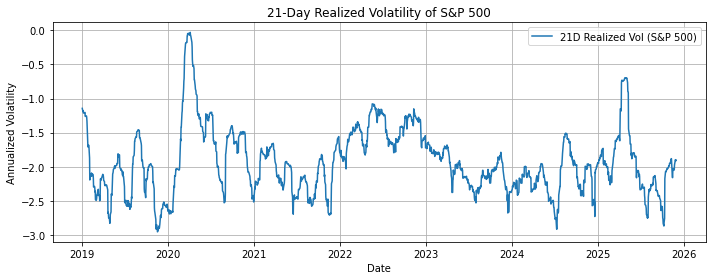

In [5]:
print("Running dispersion diagnostics...")
dispersion_diagnostics(features_df)

# Optionally save figure
Path("../figures").mkdir(exist_ok=True, parents=True)
plt.savefig("../figures/dispersion_sp500.png", dpi=150, bbox_inches="tight")
plt.show()
plt.close()

## Time-Series Train/Test Split

The dataset is split chronologically: the earlier part is used for training and the most recent ~30% of observations (approximately 2024–2025) are reserved for testing.  
This respects time ordering and mimics a real forecasting exercise.


In [6]:
X_train, X_test, y_train, y_test = time_series_train_test_split(features_df, params)

print("Train period:", y_train.index[0].date(), "to", y_train.index[-1].date())
print("Test period: ", y_test.index[0].date(), "to", y_test.index[-1].date())
print("Train size:", len(y_train), "Test size:", len(y_test))


Train size: 1200, Test size: 514
Train period: 2019-02-05 to 2023-11-08
Test period:  2023-11-09 to 2025-11-26
Train period: 2019-02-05 to 2023-11-08
Test period:  2023-11-09 to 2025-11-26
Train size: 1200 Test size: 514


## Modelling: OLS vs Elastic Net

Two models are estimated on the training set:

- Baseline OLS regression on standardized features.  
- Elastic Net with time-series cross-validation over a grid of \(\alpha\) and \(l_1\) ratios.

Both models are evaluated on the held-out test set.


In [7]:
print("Fitting OLS and Elastic Net with TimeSeriesSplit CV...")
results = fit_models_with_timeseries_cv(X_train, y_train, X_test, y_test, params)

Fitting OLS and Elastic Net with TimeSeriesSplit CV...

Baseline OLS Test RMSE: 0.374067
Elastic Net Test RMSE: 0.371264
Best l1_ratio: 0.55
Best alpha:    0.029470517025518096


## Normal vs Stress Regime Evaluation

To understand robustness, the test period is split into:

- **Normal regime**: volatility below a chosen threshold (e.g. 90th percentile of test-set vol).  
- **Stress regime**: volatility above that threshold.

RMSE is computed separately for each regime for both models.

Reporting test-set results and coefficient summary...

=== RMSE COMPARISON (TEST SET) ===
OLS RMSE:        0.374067
Elastic Net RMSE:0.371264

=== TOP FEATURES BY |COEFFICIENT| (Elastic Net) ===
BAA10Y_LAG          0.209113
VOL_LAG             0.138564
SP_RET_X_VXX       -0.087831
CREDIT_SPREAD       0.053713
EFFR_LAG           -0.041385
CREDIT_SPREAD_SQ   -0.028844
VXX_RET            -0.006735
Name: coefficient, dtype: float64

=== TOP CV MODELS (Elastic Net) ===
   l1_ratio     alpha    cv_mse   cv_rmse
0      0.55  0.029471  0.205179  0.452967
1      0.60  0.029471  0.205238  0.453032
2      0.50  0.029471  0.205998  0.453870
3      0.50  0.035565  0.206418  0.454332
4      0.75  0.024421  0.206548  0.454475
5      0.65  0.029471  0.206584  0.454515
6      0.80  0.024421  0.206630  0.454566
7      0.70  0.024421  0.207391  0.455402
8      0.85  0.024421  0.207969  0.456036
9      1.00  0.020236  0.208350  0.456453

=== NORMAL vs STRESS RMSE (TEST SET) ===
Normal regime (<= -1.5980):

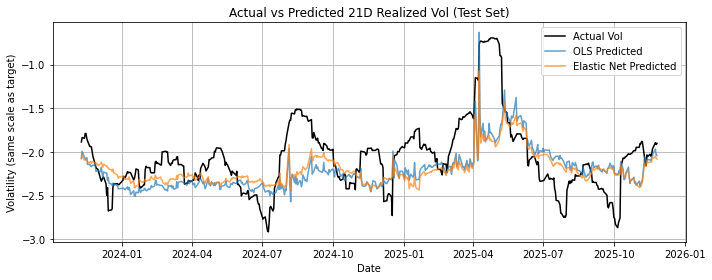

In [8]:
print("Reporting test-set results and coefficient summary...")
report_results(results, params)
plt.savefig("../figures/actual_vs_pred_vol_test.png", dpi=150, bbox_inches="tight")
plt.show()
plt.close()

## Interpreting Elastic Net Coefficients

Elastic Net yields a sparse set of non-zero coefficients.  
The largest (by absolute value) correspond to:

- `BAA10Y_LAG` – lagged corporate–Treasury spread (systemic credit risk).  
- `CPI_LAG` – inflation level.  
- `FEDFUNDS_LAG` – short-term policy rate.  
- `SP_RET_X_VXX` – interaction between equity returns and VIX-linked ETN returns.  
- `CREDIT_SPREAD_SQ` – non-linear effect of credit spreads.

These drivers summarize how credit conditions, inflation, policy rates and risk-sentiment interact to shape future equity volatility.


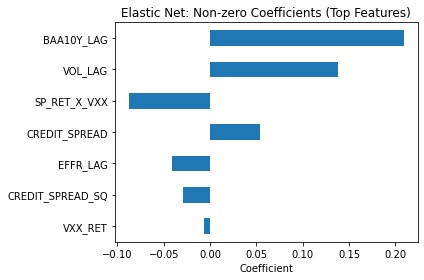

In [9]:
top_features = results["top_features"]
ax = top_features[::-1].plot(kind="barh", figsize=(6,4))
ax.set_title("Elastic Net: Non-zero Coefficients (Top Features)")
ax.set_xlabel("Coefficient")
plt.tight_layout()
plt.savefig("../figures/elastic_net_top_coefs.png", dpi=150, bbox_inches="tight")
plt.show()
plt.close()

## Conclusions

- A macro- and market-based feature set can explain a substantial share of 21-day realized volatility dynamics for the S&P 500 [finance:S&P 500].  
- Elastic Net improves test-set RMSE over OLS in normal regimes and performs comparably during stress, while shrinking weaker variables to zero and leaving a small, interpretable set of drivers.  
- Evaluating models separately in normal and stress regimes highlights both the strengths and the limitations of linear models for volatility forecasting, which is important for realistic risk management applications.
